# Starfield - Create 3D  map of starfield planes

In [11]:
starfields = [
"""
.MACRO MSTAR1
	ICVEC
	SCDOT -8,0
	SCDOT 8,0C
	SCDOT 10,0
	SCDOT 8,30
	SCDOT -30,20
	SCDOT -34,-20
	SCDOT -8,-48
	SCDOT 48,-20
	SCDOT 44,28
	SCDOT 18,50
	SCDOT -38,44
	SCDOT -48,-8
	SCDOT -40,-50
	SCDOT 10,-70
	SCDOT 58,-50
	SCDOT 68,-8
	SCDOT 58,50
	SCDOT 8,70
	SCDOT -40,68
	SCDOT -78,28
	SCDOT -70,-28
	SCDOT -70,-68
	SCVEC 0,0,0
	RTSL
""",
"""
.MACRO MSTAR2
	ICVEC
	SCDOT 8,8
	SCDOT -8,10
	SCDOT -18,-10
	SCDOT 8,-28
	SCDOT 28,-8
	SCDOT 20,20
	SCDOT 8,38
	SCDOT -20,30
	SCDOT -40,8
	SCDOT -28,-40
	SCDOT 34,-44
	SCDOT 58,18
	SCDOT 38,50
	SCDOT -10,68
	SCDOT -58,28
	SCDOT -58,-30
	SCDOT -38,-68
	SCDOT 0,-78
	SCDOT 60,-68
	SCDOT 68,-30
	RTSL
""",
"""
.MACRO MSTAR3
	ICVEC
	SCDOT 10,10
	SCDOT 0,18
	SCDOT -30,8
	SCDOT -18,-2C
	SCDOT 28,-18
	SCDOT 30,8
	SCDOT 38,38
	SCDOT 0,48
	SCDOT -38,28
	SCDOT -40,-8
	SCDOT -20,-58
	SCDOT 20,-58
	SCDOT 50,-30
	SCDOT 60,20
	SCDOT 2C,64
	SCDOT -20,68
	SCDOT -64,38
	SCDOT -68,-8
	SCDOT -60,-48
	SCDOT -28,-78
	SCDOT 40,-78
	RTSL
	.ENDM
""",
"""
.MACRO MSTAR4
	ICVEC
	SCDOT -8,-10
	SCDOT 20,-10
	SCDOT 20,18
	SCDOT -18,20
	SCDOT -30,-10
	SCDOT 10,-38
	SCDOT 40,0
	SCDOT 20,38
	SCDOT -20,48
	SCDOT -50,10
	SCDOT -38,-40
	SCDOT 18,-4C
	SCDOT 40,-38
	SCDOT 68,10
	SCDOT 28,58
	SCDOT -38,50
	SCDOT -70,18
	SCDOT -68,-18
	SCDOT -58,-78
	SCDOT 40,-60
	RTSL
"""
]

In [54]:
from itertools import groupby
from operator import itemgetter
from matplotlib import pyplot as plt
import numpy as np
import os

plt.style.use('default')
plt.rcParams['figure.dpi'] = 150


colors = {
    "TURQOI":"CYAN",
    "PDIWHI":"WHITE",
    "PDIRED":"RED",
    "PDIYEL":"YELLOW",
    "":"WHITE",
}

def vctr(color,x,y,i=""):
    x,y=int(x,16),int(y,16)
    if i == "0":
        return (x,y,"BLACK")
    return (x,y,colors.get(color,color))

def scvec(old_x,old_y,CM,CD,color,x,y,i=0):
    c = "BLACK" if i == 0 else colors.get(color,color)
    x = ((x * CM)/CD)/2 # Divide by 2: Hack the x scale to match Tempest
    y = (y * CM)/CD
    vec=(x-old_x,y-old_y,c)
    old_x = x
    old_y = y
    return (vec,old_x,old_y)

def parse_vector_commands(vector_data,default_color="red"):
    # Read in the vector commands from the Tempest source code
    # and translate them into a series of vectors, i.e. a  list of 
    # tuples of the form (x,y,color).
    # This list can then be transformed into a series of x,y co-ordinates
    # for plotting on a graph.
    CM = 1 # Scale multiplier
    CD = 1 # Scale divider
    CB = 1 # Intensity/Brightness
    color = ""
    vecs = []
    old_x,old_y = 0,0
    CALBRITE = "BLACK"
    for l in vector_data.splitlines():
        if not l.strip():
            continue
        tokens = l.strip().split()
        cmd, parms = tokens[0],tokens[1:]
        if cmd in ["ICVEC","ICALVE"]:
            vecs+=[(0,0,"BLACK")]
            old_x,old_y=0,0
        elif cmd.startswith("CM="):
            CM = int(cmd.split("=")[1])
        elif cmd.startswith("CB="):
            CB = int(cmd.split("=")[1])
        elif cmd.startswith("CD="):
            CD = int(cmd.split("=")[1])
        elif cmd == "SCDOT":
            # SCVEC
            parms = [int(x.replace('.',''),16) for x in parms[0].split(',')]
            vec,old_x,old_y = scvec(old_x,old_y,CM,CD,color,*parms)
            vecs+=[vec]
            # VCTR
            vecs+=[vctr(color,"0","0","CB")]
    return vecs

def vectors_to_coords(vectors):
    # Turns a series of vectors into a series of x,y co-ordinates
    # or vertices.
    xs,ys,cs=[],[],[]
    px,py,pc=0,0,None
    for x,y,c in vectors:
        # If we're changing color, add a vertex with the
        # new color at the old position.
        if pc and c != pc:
            xs+=[px]
            ys+=[py]
            cs+=[c]
        # Calculate the position of the new vertex
        px+=x
        py+=y
        xs+=[px]
        ys+=[py]
        cs+=[c]
        pc=c
    return list(zip(xs,ys,cs))


In [161]:
def scale(x, y, z, centre=(0,0), factor=1):
    x_mid,y_mid = centre
    x -= x_mid
    y -= y_mid
    x *= factor
    y *= factor
    x += x_mid
    y += y_mid
    return (x,y,z)

def create2DVertices(vertices):
    y = np.array([y for _,y,_ in vertices])
    x = np.array([x for x,_,_ in vertices])
    z = np.array([z for _,_,z in vertices])
    return(x,y,z)

def makeFullGraph(x, y, z, filename, titlename="", azimuth=135, elev=20,
                 xticks=True, yticks=True, zticks=True):
    #Change the Size of Graph using Figsize
    fig = plt.figure(figsize=(7,7))
    ax = plt.axes(projection='3d')
    ax.tick_params(axis='both', which='major', labelsize=10)
    if not xticks:
        ax.set_xticks([])
    if not yticks:
        ax.set_yticks([])
    if not zticks:
        ax.set_zticks([])
    plt.rcParams['grid.color'] = "navy"
    ax.scatter(x, y, z, color ='white')
    ax.view_init(azim=azimuth,elev=elev,vertical_axis="y")
    ax.xaxis.set_pane_color("black")
    ax.yaxis.set_pane_color("black")
    ax.zaxis.set_pane_color("black")
    plt.savefig(f"starfield/{filename}", transparent=True, bbox_inches='tight')
    return



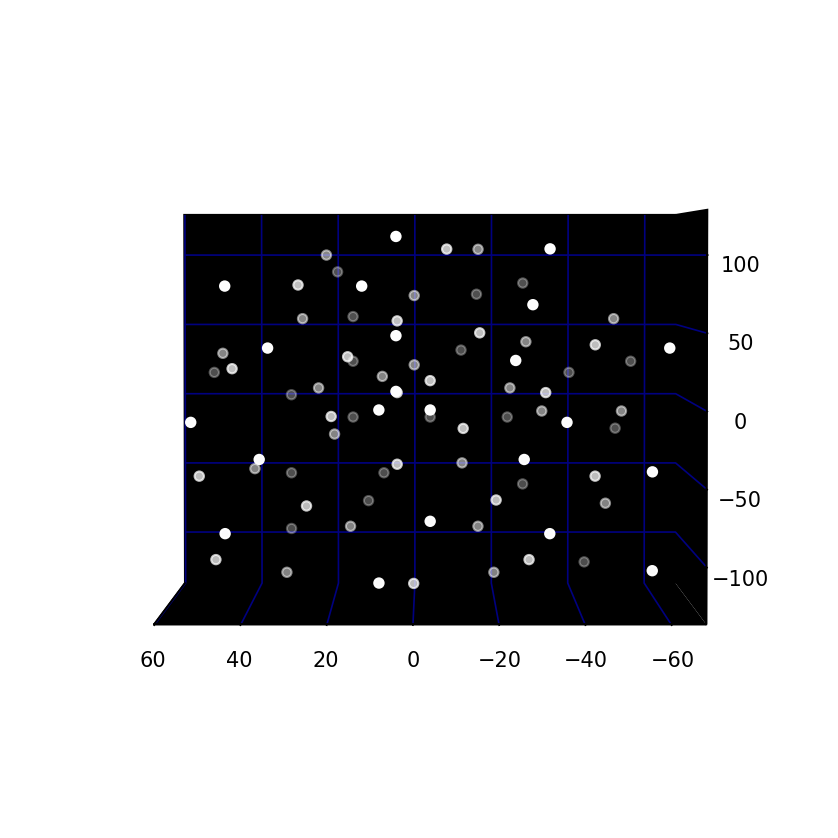

In [166]:
all_dots = []
starfield_planes = [0,1,2,3]
z_planes = [0,10,20,30]
scales = [1,1,1,1]
for z,p in enumerate(starfield_planes):
    vector_data = starfields[p]
    vectors = parse_vector_commands(vector_data,default_color="red")
    vertices = vectors_to_coords(vectors)
    dots = list(set([(x,y,z) for x,y,c in vertices if c == "WHITE"]))
    scaled_dots = [scale(x,y,z_planes[z],factor=scales[z]) for x,y,z in dots]
    all_dots += scaled_dots
x,y,z = create2DVertices(all_dots)

makeFullGraph(x, y, z, f"starfield_headon.png", azimuth=180,elev=2,zticks=False)


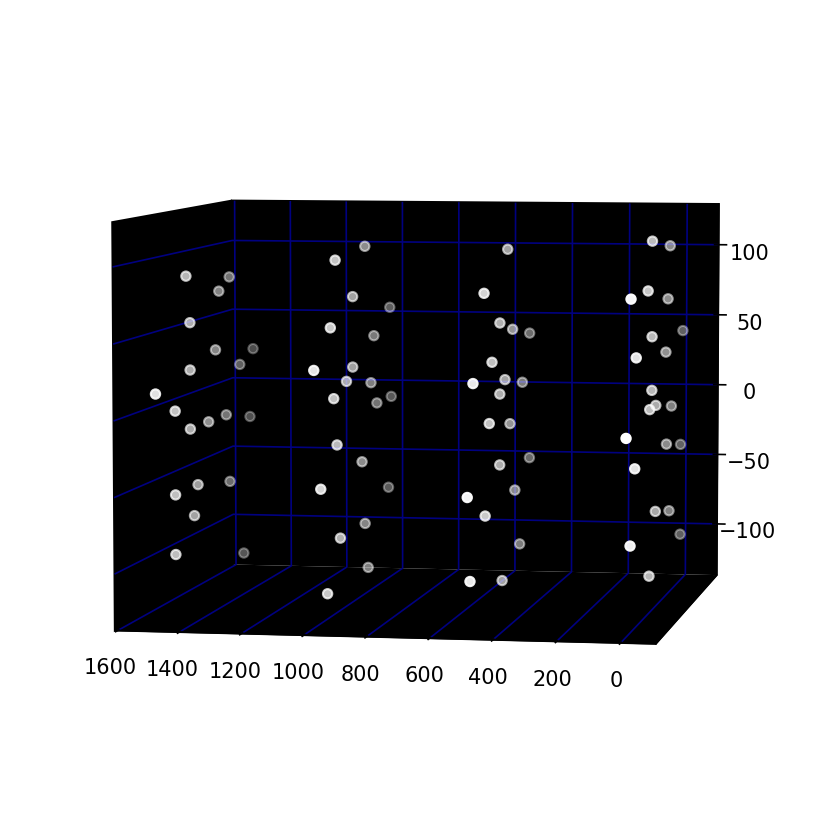

In [167]:
makeFullGraph(x, y, z, f"starfield_sideon.png", azimuth=100,elev=5, xticks=False)


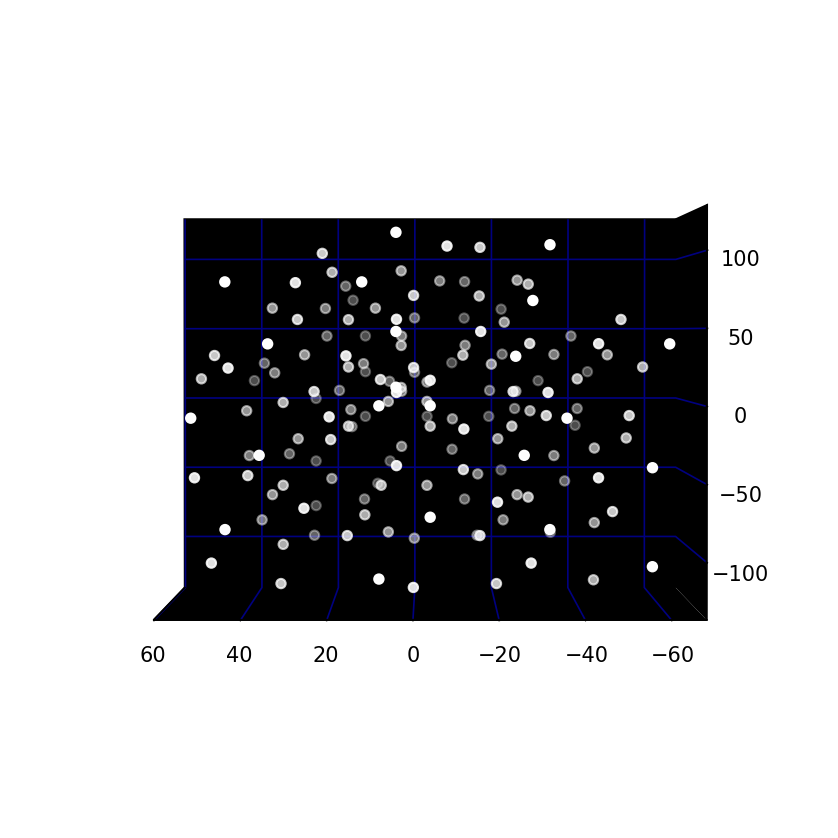

In [175]:
all_dots = []
starfield_planes = [0,1,2,3,0,1,2,3]
z_planes = [0,10,20,30,40,50,60,70]
scales = [1,1,1,1,0.8,0.8,0.8,0.8]
for z,p in enumerate(starfield_planes):
    vector_data = starfields[p]
    vectors = parse_vector_commands(vector_data,default_color="red")
    vertices = vectors_to_coords(vectors)
    dots = list(set([(x,y,z) for x,y,c in vertices if c == "WHITE"]))
    scaled_dots = [scale(x,y,z_planes[z],factor=scales[z]) for x,y,z in dots]
    all_dots += scaled_dots
x,y,z = create2DVertices(all_dots)

makeFullGraph(x, y, z, f"starfield_8_headon.png", azimuth=180,elev=1,zticks=False)


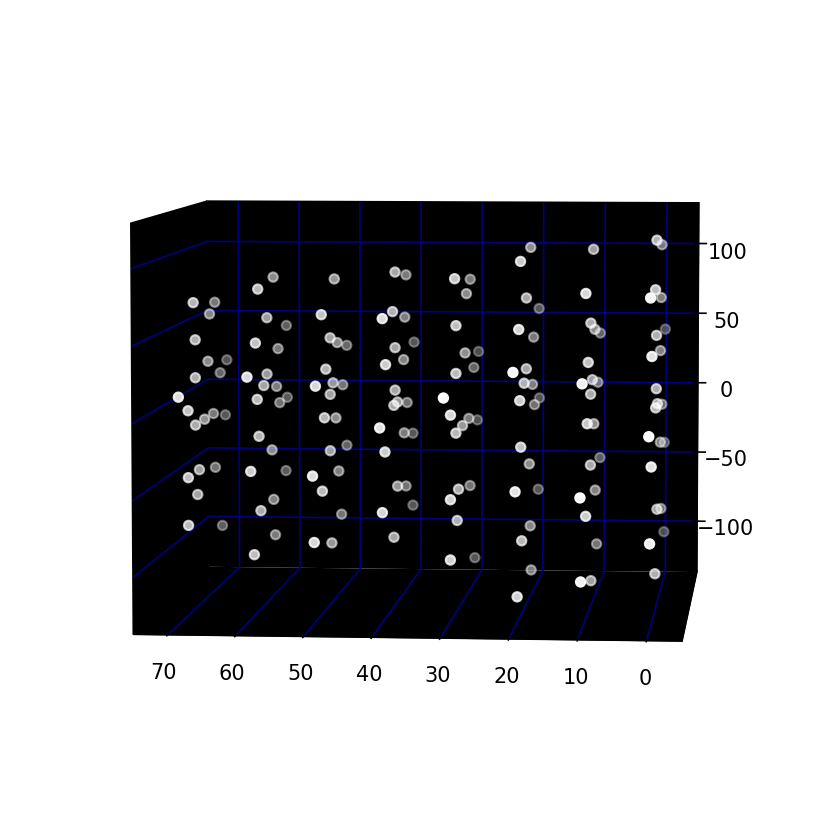

In [178]:
makeFullGraph(x, y, z, f"starfield_8_sideon.png", azimuth=95,elev=5, xticks=False)


## Emulate PRSTAR

In [239]:
def makeStarfieldGraph(x, y, z, filename, titlename="", azimuth=135, elev=20,
                 xticks=True, yticks=True, zticks=True, title=""):
    #Change the Size of Graph using Figsize
    fig = plt.figure(figsize=(7,7))
    ax = plt.axes(projection='3d')
    ax.tick_params(axis='both', which='major', labelsize=10)
    ax.set_zlim(0,255)
    if not xticks:
        ax.set_xticks([])
    if not yticks:
        ax.set_yticks([])
    if not zticks:
        ax.set_zticks([])
    plt.rcParams['grid.color'] = "navy"
    ax.scatter(x, y, z, color ='white')
    ax.view_init(azim=azimuth,elev=elev,vertical_axis="y")
    ax.xaxis.set_pane_color("black")
    ax.yaxis.set_pane_color("black")
    ax.zaxis.set_pane_color("black")
    plt.title(title,y=0.95,pad=-20,fontsize = 15)
    plt.savefig(f"starfield/{filename}", dpi=300.0, transparent=True, bbox_inches='tight',
               pad_inches=-0.4)
    plt.close()
    return

def drawStarfield(z_planes, index):
    all_dots = []
    starfield_planes = [0,1,2,3,0,1,2,3]
    scales = [1,1,1,1,0.8,0.8,0.8,0.8]
    for z,p in enumerate(starfield_planes):
        if not z_planes[z]:
            continue
        vector_data = starfields[p]
        vectors = parse_vector_commands(vector_data,default_color="red")
        vertices = vectors_to_coords(vectors)
        dots = list(set([(x,y,z) for x,y,c in vertices if c == "WHITE"]))
        scaled_dots = [scale(x,y,z_planes[z],factor=scales[z]) for x,y,z in dots]
        all_dots += scaled_dots
    x,y,z = create2DVertices(all_dots)

    makeStarfieldGraph(x, y, z, f"starfield_{index}_growing.png", 
                       azimuth=95,elev=5, xticks=False, title=str(z_planes))
PLANEYS = []
PLANEY = [0] * 7 + [0xF0]
for j in range(0,60):
    for i in range(7,-1,-1):
        cur_z = PLANEY[i]
        prev_z = PLANEY[0] if i == 7 else PLANEY[i+1]
        if cur_z:
            cur_z = cur_z - 7
            if cur_z < 0x10:
                cur_z = 0xF0
        else:
            if prev_z >0 and prev_z < 0xD5:
                cur_z = 0xF0
        PLANEY[i] = cur_z
    PLANEYS += [PLANEY.copy()]
    
for i,planey in enumerate(PLANEYS):
    drawStarfield(planey, i)

240